In [5]:
# https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/47_BERT_text_classification/BERT_email_classification-handle-imbalance.ipynb
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [6]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [8]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [9]:
747/4825

0.15481865284974095

In [10]:
# 15% spam emails, 85% ham emails: This indicates class imbalance

df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [11]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [12]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [13]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [14]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [15]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
88,ham,I'm really not up to it still tonight babe,0
4862,ham,Nokia phone is lovly..,0
3391,spam,Please CALL 08712402972 immediately as there i...,1
5112,spam,December only! Had your mobile 11mths+? You ar...,1
2168,ham,Yes.he have good crickiting mind,0


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])
X_train.head(4)

2625                          S da..al r above  &lt;#&gt;
3587    I am hot n horny and willing I live local to y...
60      Your gonna have to pick up a $1 burger for you...
735     Leaving to qatar tonite in search of an opport...
Name: Message, dtype: object

In [17]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.5132728 , -0.8884573 , ..., -0.74748874,
        -0.7531475 ,  0.9196451 ],
       [-0.8720836 , -0.50543994, -0.9444668 , ..., -0.858475  ,
        -0.71745366,  0.88082975]], dtype=float32)>

In [18]:
# Get embeding vectors for few sample words. Compare them using cosine similarity
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.99110883]], dtype=float32)

In [19]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703845]], dtype=float32)

In [20]:
# Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

cosine_similarity([e[3]],[e[4]])

array([[0.9872036]], dtype=float32)

In [21]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'sequence_output':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [23]:
len(X_train)

1120

In [24]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [26]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU


In [27]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 23s 649ms/step - loss: 0.5958 - accuracy: 0.7063 - precision: 0.7135 - recall: 0.6893
Epoch 2/10
35/35 [==============================] - 23s 661ms/step - loss: 0.4945 - accuracy: 0.8259 - precision: 0.8047 - recall: 0.8607
Epoch 3/10
35/35 [==============================] - 23s 657ms/step - loss: 0.4276 - accuracy: 0.8661 - precision: 0.8498 - recall: 0.8893
Epoch 4/10
35/35 [==============================] - 23s 656ms/step - loss: 0.3869 - accuracy: 0.8839 - precision: 0.8656 - recall: 0.9089
Epoch 5/10
35/35 [==============================] - 23s 657ms/step - loss: 0.3610 - accuracy: 0.8786 - precision: 0.8545 - recall: 0.9125
Epoch 6/10
35/35 [==============================] - 24s 673ms/step - loss: 0.3378 - accuracy: 0.8866 - precision: 0.8676 - recall: 0.9125
Epoch 7/10
35/35 [==============================] - 24s 682ms/step - loss: 0.3156 - accuracy: 0.9027 - precision: 0.8895 - recall: 0.9196
Epoch 8/10
35/35 [================

In [29]:
    model.evaluate(X_test, y_test)

12/12 [==============================] - 10s 644ms/step - loss: 0.2831 - accuracy: 0.9225 - precision: 0.9540 - recall: 0.8877


[0.2831147015094757, 0.9224599003791809, 0.954023003578186, 0.8877005577087402]

In [30]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[179,   8],
       [ 21, 166]], dtype=int64)

Text(33.0, 0.5, 'Truth')

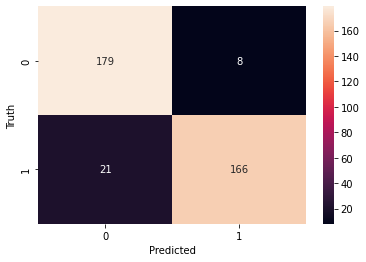

In [32]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [33]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       187
           1       0.95      0.89      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



In [34]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.72812915],
       [0.8280803 ],
       [0.76725066],
       [0.13780306],
       [0.09477236]], dtype=float32)